# 2. 다항 로지스틱 회귀 예측 모델

## 데이터 수집

In [1]:
from pandas_datareader import data as pdr
import yfinance as yfin
from datetime import date, datetime

today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = datetime(2013,1,1)

# BTC(KRW)
yfin.pdr_override()

btc_krwname = 'Bitcoin(KRW)'
btc_krw = 'BTC-KRW'
btc_krw_df = pdr.get_data_yahoo(btc_krw, start=date_start, end=date_today)

print(btc_krw_df.shape)
btc_krw_df

[*********************100%***********************]  1 of 1 completed
(3175, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,4.826118e+05,4.838110e+05,4.681210e+05,4.732035e+05,4.732035e+05,21787470960
2014-09-18,4.727130e+05,4.762765e+05,4.309914e+05,4.428182e+05,4.428182e+05,35976322560
2014-09-19,4.424667e+05,4.475154e+05,4.012784e+05,4.119893e+05,4.119893e+05,39571102935
2014-09-20,4.118610e+05,4.417305e+05,4.068624e+05,4.267118e+05,4.267118e+05,38469009780
2014-09-21,4.258571e+05,4.303872e+05,4.103040e+05,4.161897e+05,4.161897e+05,27737663355
...,...,...,...,...,...,...
2023-05-23,3.544918e+07,3.556857e+07,3.510552e+07,3.528741e+07,3.528741e+07,14530586645292
2023-05-24,3.529357e+07,3.598590e+07,3.517012e+07,3.594313e+07,3.594313e+07,18082910616976
2023-05-25,3.594165e+07,3.594165e+07,3.446848e+07,3.473084e+07,3.473084e+07,21495559019063


In [148]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from ta.volatility import BollingerBands

# 이동평균 계산
window_size = 60
btc_krw_df['MA'] = btc_krw_df['Adj Close'].rolling(window=window_size).mean()

# 볼린저 밴드 계산
indicator_bb = BollingerBands(close=btc_krw_df['Adj Close'], window=window_size, window_dev=2)
btc_krw_df['BB_upper'] = indicator_bb.bollinger_hband()
btc_krw_df['BB_middle'] = indicator_bb.bollinger_mavg()
btc_krw_df['BB_lower'] = indicator_bb.bollinger_lband()

# 데이터 전처리
data = btc_krw_df.dropna()
X = data[['MA', 'BB_upper', 'BB_middle', 'BB_lower']].values
y = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 모델 생성
model = LogisticRegression()

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred = model.predict(X_test)

# 정확도 계산
accuracy = np.mean(y_pred == y_test)

# 정확도 출력
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.5424836601307189


In [161]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import zscore
from ta.trend import MACD
from ta.momentum import RSIIndicator

# 이동평균 계산
window_size = 60
btc_krw_df['MA'] = btc_krw_df['Adj Close'].rolling(window=window_size).mean()

# MACD 계산
indicator_macd = MACD(close=btc_krw_df['Adj Close'], window_slow=26, window_fast=12, window_sign=9)
btc_krw_df['MACD'] = indicator_macd.macd()

# RSI 계산
indicator_rsi = RSIIndicator(close=btc_krw_df['Adj Close'], window=14)
btc_krw_df['RSI'] = indicator_rsi.rsi()

# 데이터 전처리
data = btc_krw_df.dropna()
X = data[['MA', 'MACD', 'RSI']].values
y = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)

# 이상치 처리
z_scores = np.abs(zscore(X))
threshold = 3
outlier_indices = np.where(z_scores > threshold)
X_clean = np.delete(X, outlier_indices[0], axis=0)
y_clean = np.delete(y, outlier_indices[0])

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_clean, test_size=0.2, random_state=42)

# 하이퍼파라미터 조합 리스트
param_combinations = [
    {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100},
    {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100},
    {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100},
    {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100},
    {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100},
    {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 100},
    {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 100},
    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 100},
    {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 100},
    {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 100}
]

best_accuracy = 0
best_params = {}

# 하이퍼파라미터 조합 시도
for params in param_combinations:
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

# 최적의 모델 생성 및 학습
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 정확도, 정밀도, 재현율, F1 스코어 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 평가 지표 출력
print(f"Best Parameters: {best_params}")
print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Best Parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 100}
Test Accuracy: 0.554806070826307
Precision: 0.5555555555555556
Recall: 0.975609756097561
F1 Score: 0.7079646017699116


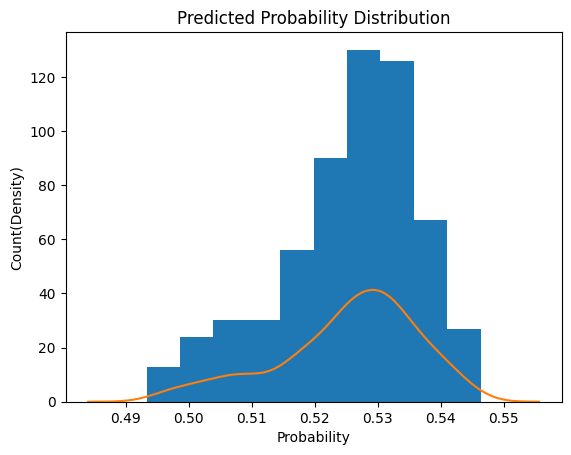

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 예측 확률값 얻기
y_prob = best_model.predict_proba(X_test)
y_prob_positive = y_prob[:, 1]  # 양성 클래스(1)에 대한 예측 확률값

# 히스토그램 시각화
plt.hist(y_prob_positive, bins=10)
sns.kdeplot(y_prob_positive) # KDE 플롯 시각화
plt.title('Predicted Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count(Density)')
plt.show()

In [178]:
# 예측할 데이터 준비
future_data = btc_krw_df.tail(1)[['MA', 'MACD', 'RSI']].values
future_data_scaled = scaler.transform(future_data)

# 예측 시점과 타겟 시점 추출
prediction_date = btc_krw_df.tail(1).index[0]
target_date = btc_krw_df.index[-1] + pd.DateOffset(days=1)

# 모델을 사용하여 미래 상승 또는 하락 예측
future_prediction = best_model.predict(future_data_scaled)
future_probabilities = best_model.predict_proba(future_data_scaled)

# 예측 결과 표시
if future_prediction[0] == 1:
    prediction_result = '상승'
    probability = future_probabilities[0][1] * 100
else:
    prediction_result = '하락'
    probability = future_probabilities[0][0] * 100

print(f"예측 시점: {prediction_date}")
print(f"타겟 시점: {target_date}")
print(f"예측 결과: {prediction_result} | {probability:.2f}%")

예측 시점: 2023-05-27 00:00:00
타겟 시점: 2023-05-28 00:00:00
예측 결과: 상승 | 51.06%
